In [1]:
import numpy as np
from ase import Atoms
import ase.visualize
from ase.units import Bohr
from pyscf import gto, scf, mp, cc, dft
import glob
from matplotlib import pyplot as plt

import pandas as pd
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
from parse_density_files import CUBE
import alchemy_tools2 as at
import explore_qml_data as eqd


In [3]:
def get_data(data):
    e_npbc = []
    for d in data:
        e_npbc.append(d['e_nbpc'])
    e_npbc = np.array(e_npbc)
    
    e_scaled = []
    for d in data:
        e_scaled.append(d['e_scaled'])
    e_scaled = np.array(e_scaled)

    e_el = []
    for d in data:
        e_el.append(d['e_el'])
    e_el = np.array(e_el)

    e_tot = []
    for d in data:
        e_tot.append(d['e_tot'])
    e_tot = np.array(e_tot)

    alchpots = []
    for d, e in zip(data, e_el):
        alchpots.append(e/d['nuclei'][:,0])
    alchpots = np.array(alchpots)
    
    return(alchpots, e_el, e_npbc, e_scaled, e_tot)

### Angles - butanol CCO

In [4]:
paths_glob = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol_plane/ang_*/results.dict')

angle = []
for p in paths_glob:
    angle.append(float(p.split('/')[-2].split('_')[-1]))
paths = []
for p,a in zip(paths_glob,angle):
    paths.append((a,p))
paths.sort()
angle.sort()
data = []
for p in paths:
    data.append(uqm.load_obj(p[1]))
    
geometries = dict()
for d in data:
    nuc_charges = d['nuclei'][:,0]
    pos = d['nuclei'][:,1:]*Bohr
    pos = eqd.shift2center(pos, [0,0,0])
    molecule = Atoms(numbers=nuc_charges, positions=pos)
    ang = np.round(molecule.get_angle(1, 2,4))
    geometries[f'ang_{ang}'] = molecule

alchpots, e_el, e_npbc, e_scaled, e_tot = get_data(data)

nuc_rep = []
for et, el in zip(e_tot, e_el):
    nuc_rep.append((et-el).sum())
nuc_rep = np.array(nuc_rep)

#### Pairwise distance vs angle

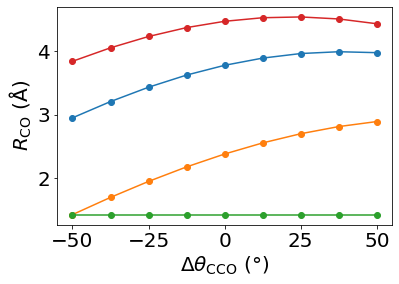

In [28]:
plt.rcParams['font.size'] = 20
dist_O = []
for i in range(4):
    dist = []
    for k in geometries.keys():
        dist.append(geometries[k].get_distance(i,4))
    dist_O.append(dist)
    plt.plot(angle, dist, '-o', label=i)
plt.xlabel(r'$\Delta\theta_{\rm{CCO}}$ (°)')
plt.ylabel(r'$R_{\rm{CO}}$ ($\rm{\AA}$)')
plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/angle_dist_CO.svg', bbox_inches='tight')

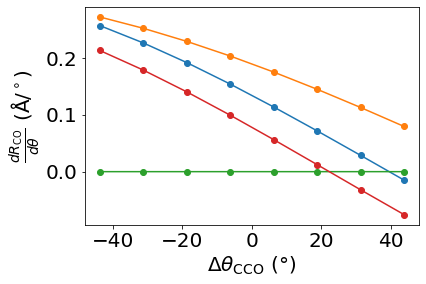

In [29]:
plt.rcParams['font.size'] = 20

for dist in dist_O:
    der = []
    der_angle = []
    for i in range(len(dist)-1):
        der.append(dist[i+1] - dist[i])
        der_angle.append((angle[i+1] + angle[i])/2)

    plt.plot(der_angle, der, '-o')
    
plt.xlabel(r'$\Delta\theta_{\rm{CCO}}$ (°)')
plt.ylabel(r'$\frac{d R_{\rm{CO}} }{d\theta}$ ($\rm{\AA}/^\circ$)')

plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/deri_angle_dist_CO.svg', bbox_inches='tight')

In [13]:
der_angle

[6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25]

#### Total energy molecule

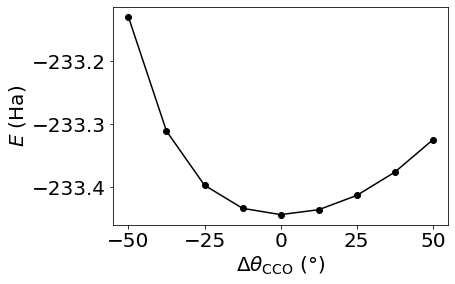

In [32]:
plt.rcParams['figure.figsize'] = [6,4]

plt.rcParams['font.size'] = 20
plt.plot(angle, e_npbc, '-o', color='black')
plt.xlabel(r'$\Delta\theta_{\rm{CCO}}$ (°)')
plt.ylabel(r'$E$ (Ha)')
#plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/angle_total_energy_mol.png', bbox_inches='tight')

#### Electronic energy molecule

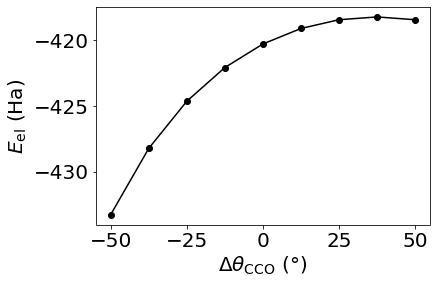

In [31]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['font.size'] = 20
plt.plot(angle, e_npbc-nuc_rep, '-o', color='black')
plt.xlabel(r'$\Delta\theta_{\rm{CCO}}$ (°)')
plt.ylabel(r'$E_{\rm{el}}$ (Ha)')
#plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/angle_electronic_energy_mol.png', bbox_inches='tight')

#### Alchemical potentials

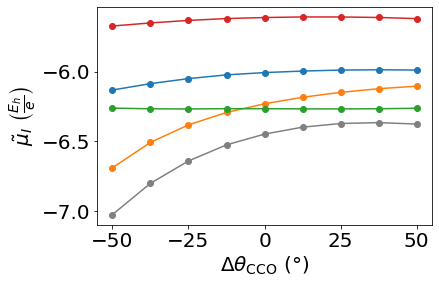

In [36]:
plt.rcParams['figure.figsize'] = [6,4]
fig, ax = plt.subplots(1,1)

at = 'heavy'
#at = 'hydrogens'

if at == 'heavy':
    ax.plot(angle, alchpots[:,0], '-o',label='C0')
    ax.plot(angle, alchpots[:,1], '-o',label='C1')
    ax.plot(angle, alchpots[:,2], '-o',label='C2')
    ax.plot(angle, alchpots[:,3], '-o',label='C3')
    ax.plot(angle, alchpots[:,4], '-o', label='O', color='grey')

    
# Hydrogens
if at == 'hydrogens':
    # C0
    ax.plot(angle, alchpots[:,5], '-o', color='tab:blue')
    ax.plot(angle, alchpots[:,6], '-o', color='tab:blue')
    # C1
    ax.plot(angle, alchpots[:,7], '-o', color='tab:orange')
    ax.plot(angle, alchpots[:,8], '-o', color='tab:orange')
    # C2
    ax.plot(angle, alchpots[:,9], '-o', color='tab:green')
    ax.plot(angle, alchpots[:,10], '-o', color='tab:green')
    # C3
    ax.plot(angle, alchpots[:,11], '-o', color='tab:red')
    ax.plot(angle, alchpots[:,12], '-o', color='tab:red')
    ax.plot(angle, alchpots[:,13], '-o', color='tab:red')
    # O
    ax.plot(angle, alchpots[:,14], '-o', color='tab:grey')

ax.set_xlabel(r'$\Delta\theta_{\rm{CCO}}$ (°)')
ax.set_ylabel(r'$\tilde{\mu}_I$ $\left(\frac{E_h}{e}\right)$')
#plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/angle_mu_hydrogens.png', bbox_inches='tight')
plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/angle_mu_heavy_atoms.png', bbox_inches='tight')

Text(0.5, 0, '$\\Delta \\theta$ (°)')

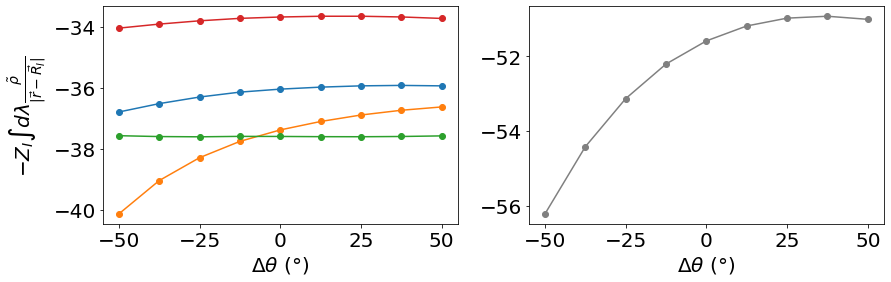

In [27]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_el[:,0], '-o',label='C0')
ax[0].plot(angle, e_el[:,1], '-o',label='C1')
ax[0].plot(angle, e_el[:,2], '-o',label='C2')
ax[0].plot(angle, e_el[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
#ax[0].legend()
ax[0].set_xlabel(r'$\Delta \theta$ (°)')

ax[0].set_ylabel(r'$-Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|}$')


ax[1].plot(angle, e_el[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\Delta \theta$ (°)')
#ax[1].set_ylabel(r'$Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|}$')
#ax[1].legend()

Text(0.5, 0, '$\\Delta\\theta$ (°)')

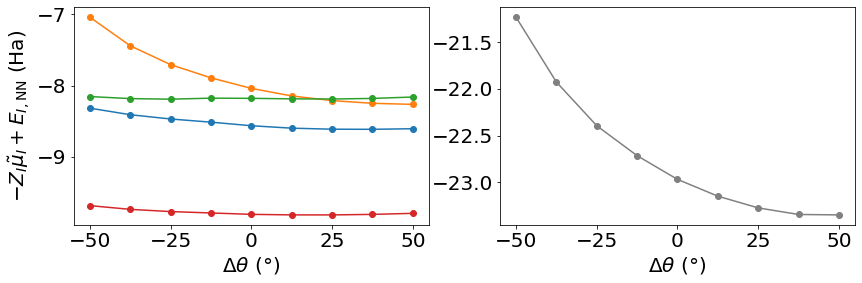

In [12]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_tot[:,0], '-o',label='C0')
ax[0].plot(angle, e_tot[:,1], '-o',label='C1')
ax[0].plot(angle, e_tot[:,2], '-o',label='C2')
ax[0].plot(angle, e_tot[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].set_xlabel(r'$\Delta\theta$ (°)')

#ax[0].set_ylabel(r'$-Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|} + E_{\rm{NN}}$')
ax[0].set_ylabel(r'$-Z_I \tilde{\mu}_I + E_{I, \rm{NN}}$ (Ha)')

ax[1].plot(angle, e_tot[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\Delta\theta$ (°)')
#ax[1].set_ylabel(r'$Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|} + E_{\rm{NN}}$')
#ax[1].legend()

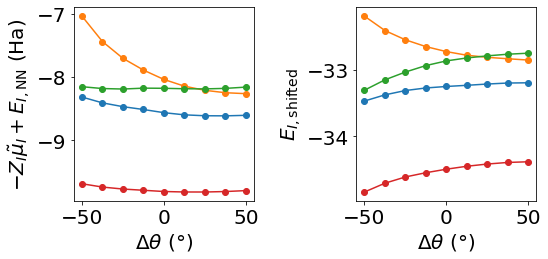

In [17]:
plt.rcParams['figure.figsize'] = [8,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_tot[:,0], '-o',label='C0')
ax[0].plot(angle, e_tot[:,1], '-o',label='C1')
ax[0].plot(angle, e_tot[:,2], '-o',label='C2')
ax[0].plot(angle, e_tot[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].set_xlabel(r'$\Delta\theta$ (°)')

#ax[0].set_ylabel(r'$-Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|} + E_{\rm{NN}}$')
ax[0].set_ylabel(r'$-Z_I \tilde{\mu}_I + E_{I, \rm{NN}}$ (Ha)')

ax[1].set_xlabel(r'$\Delta\theta$ (°)')

# Carbon
ax[1].plot(angle, e_scaled[:,0], '-o',label='C0')
ax[1].plot(angle, e_scaled[:,1], '-o',label='C1')
ax[1].plot(angle, e_scaled[:,2], '-o',label='C2')
ax[1].plot(angle, e_scaled[:,3], '-o',label='C3')

ax[1].set_ylabel(r'$E_{I, \rm{shifted}}$')
fig.tight_layout()

In [ ]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_scaled[:,0], '-o',label='C0')
ax[0].plot(angle, e_scaled[:,1], '-o',label='C1')
ax[0].plot(angle, e_scaled[:,2], '-o',label='C2')
ax[0].plot(angle, e_scaled[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].set_xlabel(r'$\Delta\theta$ (°)')

ax[0].set_ylabel(r'$E_{\rm{scaled}}$')

ax[1].plot(angle, e_scaled[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\Delta\theta$ (°)')
#ax[1].set_ylabel(r'$E_{\rm{scaled}}$')
#ax[1].legend()

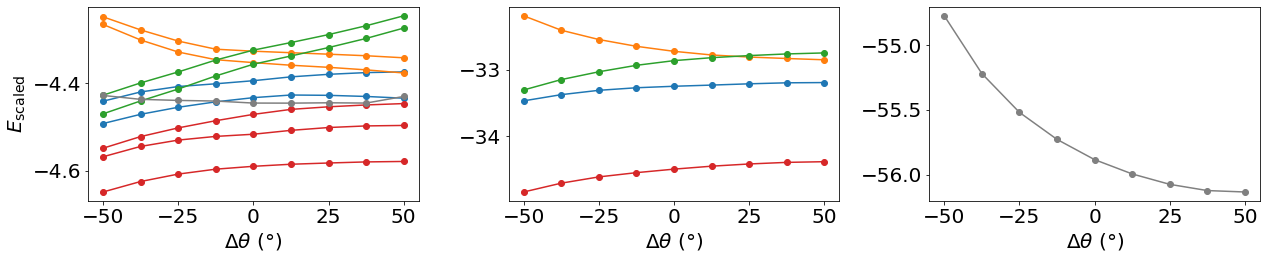

In [13]:
plt.rcParams['figure.figsize'] = [18,4]
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(1,3)

# Hydrogens
# C0
ax[0].plot(angle, e_scaled[:,5], '-o', color='tab:blue')
ax[0].plot(angle, e_scaled[:,6], '-o', color='tab:blue')
# C1
ax[0].plot(angle, e_scaled[:,7], '-o', color='tab:orange')
ax[0].plot(angle, e_scaled[:,8], '-o', color='tab:orange')
# C2
ax[0].plot(angle, e_scaled[:,9], '-o', color='tab:green')
ax[0].plot(angle, e_scaled[:,10], '-o', color='tab:green')
# C3
ax[0].plot(angle, e_scaled[:,11], '-o', color='tab:red')
ax[0].plot(angle, e_scaled[:,12], '-o', color='tab:red')
ax[0].plot(angle, e_scaled[:,13], '-o', color='tab:red')
# O
ax[0].plot(angle, e_scaled[:,14], '-o', color='tab:grey')

ax[0].set_xlabel(r'$\Delta\theta$ (°)')
ax[0].set_ylabel(r'$E_{\rm{scaled}}$')

# Carbon
ax[1].plot(angle, e_scaled[:,0], '-o',label='C0')
ax[1].plot(angle, e_scaled[:,1], '-o',label='C1')
ax[1].plot(angle, e_scaled[:,2], '-o',label='C2')
ax[1].plot(angle, e_scaled[:,3], '-o',label='C3')
#ax[1].legend(bbox_to_anchor=(1.05,1))
ax[1].set_xlabel(r'$\Delta\theta$ (°)')

# Oxygen
ax[2].plot(angle, e_scaled[:,4], '-o', label='O', color='grey')
ax[2].set_xlabel(r'$\Delta\theta$ (°)')

fig.tight_layout()

# CO-bond butanol

In [30]:
paths_glob = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/dist*/results.dict')
angle = []
for p in paths_glob:
    angle.append(float(p.split('/')[-2].split('_')[-1]))
paths = []
for p,a in zip(paths_glob,angle):
    paths.append((a,p))
paths.sort()
angle.sort()
data = []
for p in paths:
    data.append(uqm.load_obj(p[1]))
    
geometries = dict()
for d in data:
    nuc_charges = d['nuclei'][:,0]
    pos = d['nuclei'][:,1:]*Bohr
    pos = eqd.shift2center(pos, [0,0,0])
    molecule = Atoms(numbers=nuc_charges, positions=pos)
    ang = np.round(molecule.get_distance(2,4), 3)
    geometries[f'ang_{ang}'] = molecule

alchpots, e_el, e_npbc, e_scaled, e_tot = get_data(data)

nuc_rep = []
for et, el in zip(e_tot, e_el):
    nuc_rep.append((et-el).sum())
nuc_rep = np.array(nuc_rep)

### Why are atomic energies non-bonding?

In [31]:
e_tot_pbc = [-44.26468902,  -44.53715770, -44.66410095, -44.71612940, -44.72975981, -44.70955433, -44.67218598, -44.63680111, -44.60796255]
e_tot_pbc = np.array(e_tot_pbc)
e_el_pbc = e_tot_pbc - nuc_rep
e_tot_atomic = []
for e in e_tot:
    e_tot_atomic.append(e.sum())
e_tot_atomic = np.array(e_tot_atomic)
e_el_atomic = e_tot_atomic - nuc_rep

e_el_npbc = e_npbc - nuc_rep

In [32]:
# atomic energies with effective charges
def get_Z_eff(Z):
    if Z == 1:
        return(0.7)
    else:
        n_ve = Z-2 # number valence electrons second shell
        S = 2*0.85+(n_ve-1)*0.35 # shielding constant
        return(Z-S)
# def get_Z_eff(Z):
#     if Z == 1:
#         return(1)
#     elif Z==6:
#         return(5.673)
#     elif Z == 8:
#         return(7.658)
    
nuclei = data[0]['nuclei'][:,0]
e_el_eff = []
for energies in e_el:
    energies_effective = []
    for e, Z in zip(energies, nuclei):
        Z_eff = get_Z_eff(Z)
        energies_effective.append(Z_eff/Z*e)
    e_el_eff.append(energies_effective)
e_el_eff = np.array(e_el_eff)

# electronic energy
e_el_atomic_eff = []
for e in e_el_eff:
    e_el_atomic_eff.append(e.sum())

e_el_atomic_eff = np.array(e_el_atomic_eff)
# nuclear repulsion
nuc_eff = []
for Z in nuclei:
    Z_eff = get_Z_eff(Z)
    nuc_eff.append(Z_eff)
nuc_rep_eff = []
for i in range(len(data)):
    nuc_rep_eff.append(at.nuclear_repulsion(nuc_eff, data[i]['nuclei'][:,1:]).sum())
nuc_rep_eff = np.array(nuc_rep_eff)


### Total energy SCF

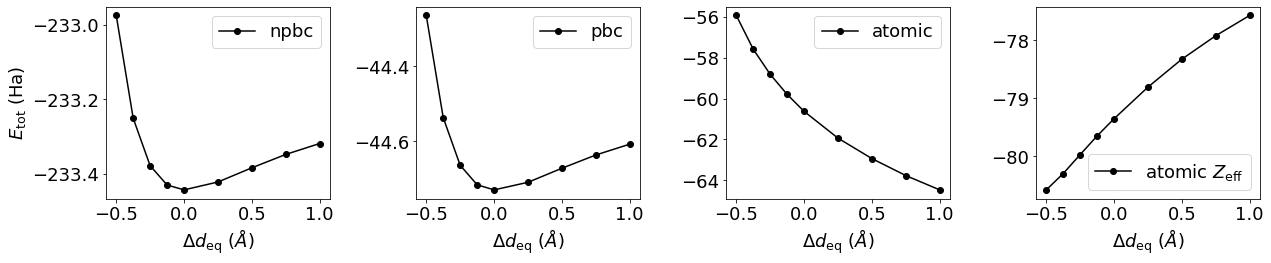

In [41]:
plt.rcParams['figure.figsize'] = [18,4]
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,4)
ax[0].plot(angle, e_npbc, '-o', color='black', label = 'npbc')
ax[1].plot(angle, e_tot_pbc, '-o', color='black', label = 'pbc')
ax[2].plot(angle, e_tot_atomic, '-o', color='black', label = 'atomic')
ax[3].plot(angle, e_el_atomic_eff+nuc_rep_eff, '-o', color='black', label = r'atomic $Z_{\rm{eff}}$')


ax[0].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax[2].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax[3].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].set_ylabel(r'$E_{\rm{tot}}$ (Ha)')
fig.tight_layout()
#plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/etot_scf_bond.png', bbox_inches='tight')

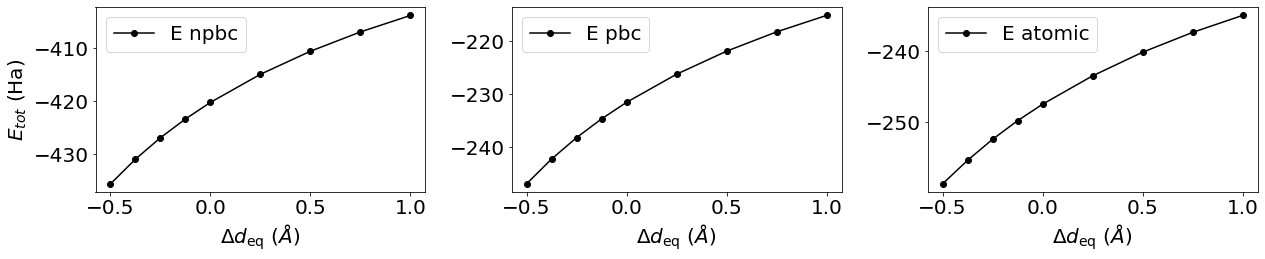

In [33]:
plt.rcParams['figure.figsize'] = [18,4]
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,3)
ax[0].plot(angle, e_el_npbc, '-o', color='black', label = 'E npbc')
ax[1].plot(angle, e_el_pbc, '-o', color='black', label = 'E pbc')
ax[2].plot(angle, e_el_atomic, '-o', color='black', label = 'E atomic')

ax[0].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax[2].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_ylabel(r'$E_{tot}$ (Ha)')
fig.tight_layout()

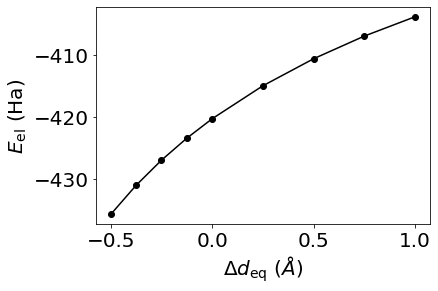

In [5]:
nuc_rep = []
for et, el in zip(e_tot, e_el):
    nuc_rep.append((et-el).sum())
nuc_rep = np.array(nuc_rep)
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['font.size'] = 20
plt.plot(angle, e_npbc-nuc_rep, '-o', color='black')
plt.xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
plt.ylabel(r'$E_{\rm{el}}$ (Ha)')

#plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/eel_scf_bond.png', bbox_inches='tight')

Text(0, 0.5, '$E_{\\rm{el}}$ (Ha)')

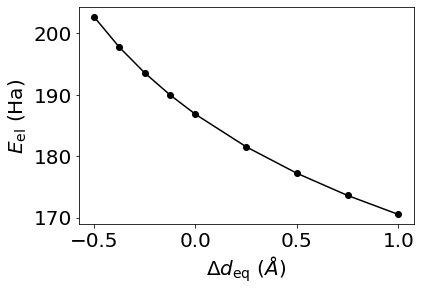

In [8]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['font.size'] = 20
plt.plot(angle, nuc_rep, '-o', color='black')
plt.xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
plt.ylabel(r'$E_{\rm{el}}$ (Ha)')

### Alchemical potential

Text(0, 0.5, '$\\tilde{\\mu}_I$ $\\left(\\frac{E_h}{e}\\right)$')

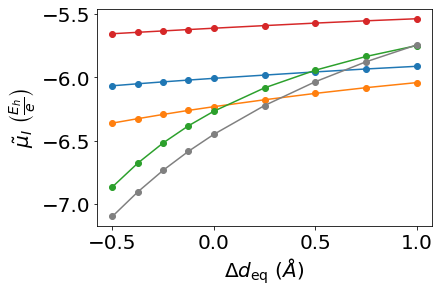

In [6]:
plt.rcParams['figure.figsize'] = [6,4]
fig, ax = plt.subplots(1,1)

at = 'heavy'
#at = 'hydrogens'

if at == 'heavy':
    ax.plot(angle, alchpots[:,0], '-o',label='C0')
    ax.plot(angle, alchpots[:,1], '-o',label='C1')
    ax.plot(angle, alchpots[:,2], '-o',label='C2')
    ax.plot(angle, alchpots[:,3], '-o',label='C3')
    ax.plot(angle, alchpots[:,4], '-o', label='O', color='grey')

    
# Hydrogens
if at == 'hydrogens':
    # C0
    ax.plot(angle, alchpots[:,5], '-o', color='tab:blue')
    ax.plot(angle, alchpots[:,6], '-o', color='tab:blue')
    # C1
    ax.plot(angle, alchpots[:,7], '-o', color='tab:orange')
    ax.plot(angle, alchpots[:,8], '-o', color='tab:orange')
    # C2
    ax.plot(angle, alchpots[:,9], '-o', color='tab:green')
    ax.plot(angle, alchpots[:,10], '-o', color='tab:green')
    # C3
    ax.plot(angle, alchpots[:,11], '-o', color='tab:red')
    ax.plot(angle, alchpots[:,12], '-o', color='tab:red')
    ax.plot(angle, alchpots[:,13], '-o', color='tab:red')
    # O
    ax.plot(angle, alchpots[:,14], '-o', color='tab:grey')

ax.set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax.set_ylabel(r'$\tilde{\mu}_I$ $\left(\frac{E_h}{e}\right)$')
#plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/mu_heavy_atoms.png', bbox_inches='tight')

Text(0.5, 0, '$\\Delta d_{\\rm{eq}}$ ($\\AA$)')

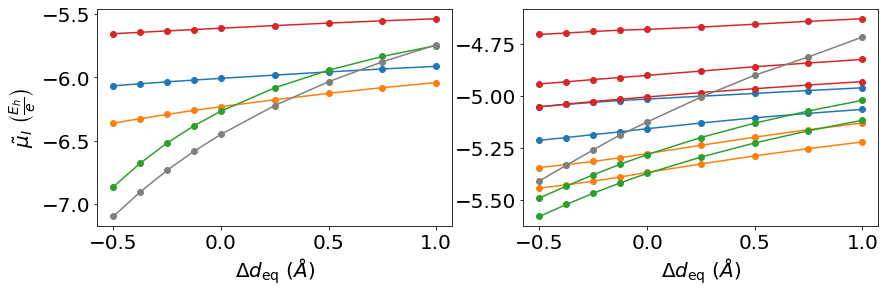

In [7]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, alchpots[:,0], '-o',label='C0')
ax[0].plot(angle, alchpots[:,1], '-o',label='C1')
ax[0].plot(angle, alchpots[:,2], '-o',label='C2')
ax[0].plot(angle, alchpots[:,3], '-o',label='C3')
ax[0].plot(angle, alchpots[:,4], '-o', label='O', color='grey')
#ax[0].legend(bbox_to_anchor=(1.05,1))
#ax[0].legend()
ax[0].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax[0].set_ylabel(r'$\tilde{\mu}_I$ $\left(\frac{E_h}{e}\right)$')

# Hydrogens
# C0
ax[1].plot(angle, alchpots[:,5], '-o', color='tab:blue')
ax[1].plot(angle, alchpots[:,6], '-o', color='tab:blue')
# C1
ax[1].plot(angle, alchpots[:,7], '-o', color='tab:orange')
ax[1].plot(angle, alchpots[:,8], '-o', color='tab:orange')
# C2
ax[1].plot(angle, alchpots[:,9], '-o', color='tab:green')
ax[1].plot(angle, alchpots[:,10], '-o', color='tab:green')
# C3
ax[1].plot(angle, alchpots[:,11], '-o', color='tab:red')
ax[1].plot(angle, alchpots[:,12], '-o', color='tab:red')
ax[1].plot(angle, alchpots[:,13], '-o', color='tab:red')
# O
ax[1].plot(angle, alchpots[:,14], '-o', color='tab:grey')

ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
#ax[1].set_ylabel(r'$Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|}$')
#ax[1].legend()

In [ ]:
angle

### Electronic energy

In [ ]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_el[:,0], '-o',label='C0')
ax[0].plot(angle, e_el[:,1], '-o',label='C1')
ax[0].plot(angle, e_el[:,2], '-o',label='C2')
ax[0].plot(angle, e_el[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].legend()
ax[0].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

ax[0].set_ylabel(r'$-Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|}$')


ax[1].plot(angle, e_el[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
#ax[1].set_ylabel(r'$Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|}$')
#ax[1].legend()

In [ ]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_tot[:,0], '-o',label='C0')
ax[0].plot(angle, e_tot[:,1], '-o',label='C1')
ax[0].plot(angle, e_tot[:,2], '-o',label='C2')
ax[0].plot(angle, e_tot[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

ax[0].set_ylabel(r'$-Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|} + E_{\rm{NN}}$')


ax[1].plot(angle, e_tot[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
#ax[1].set_ylabel(r'$Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|} + E_{\rm{NN}}$')
#ax[1].legend()

In [ ]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_scaled[:,0], '-o',label='C0')
ax[0].plot(angle, e_scaled[:,1], '-o',label='C1')
ax[0].plot(angle, e_scaled[:,2], '-o',label='C2')
ax[0].plot(angle, e_scaled[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

ax[0].set_ylabel(r'$E_{\rm{scaled}}$')

ax[1].plot(angle, e_scaled[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
#ax[1].set_ylabel(r'$E_{\rm{scaled}}$')
#ax[1].legend()

In [ ]:
plt.rcParams['figure.figsize'] = [18,4]
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(1,3)

# Hydrogens
# C0
ax[0].plot(angle, e_scaled[:,5], '-o', color='tab:blue')
ax[0].plot(angle, e_scaled[:,6], '-o', color='tab:blue')
# C1
ax[0].plot(angle, e_scaled[:,7], '-o', color='tab:orange')
ax[0].plot(angle, e_scaled[:,8], '-o', color='tab:orange')
# C2
ax[0].plot(angle, e_scaled[:,9], '-o', color='tab:green')
ax[0].plot(angle, e_scaled[:,10], '-o', color='tab:green')
# C3
ax[0].plot(angle, e_scaled[:,11], '-o', color='tab:red')
ax[0].plot(angle, e_scaled[:,12], '-o', color='tab:red')
ax[0].plot(angle, e_scaled[:,13], '-o', color='tab:red')
# O
ax[0].plot(angle, e_scaled[:,14], '-o', color='tab:grey')

ax[0].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')
ax[0].set_ylabel(r'$E_{\rm{scaled}}$')

# Carbon
ax[1].plot(angle, e_scaled[:,0], '-o',label='C0')
ax[1].plot(angle, e_scaled[:,1], '-o',label='C1')
ax[1].plot(angle, e_scaled[:,2], '-o',label='C2')
ax[1].plot(angle, e_scaled[:,3], '-o',label='C3')
#ax[1].legend(bbox_to_anchor=(1.05,1))
ax[1].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

# Oxygen
ax[2].plot(angle, e_scaled[:,4], '-o', label='O', color='grey')
ax[2].set_xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

fig.tight_layout()

In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
fig, ax = plt.subplots(1,1)

# C0
plt.plot(angle, e_scaled[:,5], '-o', color='tab:blue')
plt.plot(angle, e_scaled[:,6], '-o', color='tab:blue')
# C1
plt.plot(angle, e_scaled[:,7], '-o', color='tab:orange')
plt.plot(angle, e_scaled[:,8], '-o', color='tab:orange')
# C2
plt.plot(angle, e_scaled[:,9], '-o', color='tab:green')
plt.plot(angle, e_scaled[:,10], '-o', color='tab:green')
# C3
plt.plot(angle, e_scaled[:,11], '-o', color='tab:red')
plt.plot(angle, e_scaled[:,12], '-o', color='tab:red')
plt.plot(angle, e_scaled[:,13], '-o', color='tab:red')
# O
plt.plot(angle, e_scaled[:,14], '-o', color='tab:grey')

#ax[0].legend(bbox_to_anchor=(1.05,1))
plt.xlabel(r'$\Delta d_{\rm{eq}}$ ($\AA$)')

plt.ylabel(r'$E_{\rm{scaled}}$')


# CCCO-dihedral butanol

In [3]:
paths_glob = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/dihedrals/butanol/dihe*/results.dict')
angle = []
for p in paths_glob:
    angle.append(float(p.split('/')[-2].split('_')[-1]))
paths = []
for p,a in zip(paths_glob,angle):
    paths.append((a,p))
paths.sort()
angle.sort()
data = []
for p in paths:
    data.append(uqm.load_obj(p[1]))
    
geometries = dict()
for d in data:
    nuc_charges = d['nuclei'][:,0]
    pos = d['nuclei'][:,1:]*Bohr
    pos = eqd.shift2center(pos, [0,0,0])
    molecule = Atoms(numbers=nuc_charges, positions=pos)
    ang = np.round(molecule.get_dihedral(0,1,2,4), 3)
    geometries[f'ang_{ang}'] = molecule

alchpots, e_el, e_npbc, e_scaled, e_tot = get_data(data)

nuc_rep = []
for et, el in zip(e_tot, e_el):
    nuc_rep.append((et-el).sum())
nuc_rep = np.array(nuc_rep)

In [5]:
geometries.keys()

dict_keys(['ang_0.0', 'ang_30.0', 'ang_60.0', 'ang_90.0', 'ang_120.0', 'ang_150.0', 'ang_180.0'])

In [39]:
but1 = Atoms(numbers = data[1]['nuclei'][:,0], positions=data[1]['nuclei'][:,1:])
butm1 = Atoms(numbers = data[-1]['nuclei'][:,0], positions=data[-1]['nuclei'][:,1:])


In [40]:
butm1.get_all_distances()[3]-but1.get_all_distances()[3]

array([-5.51671069e-07, -5.67074351e-07, -7.03443662e-07,  0.00000000e+00,
        3.45911432e+00, -6.95551154e-07,  1.24044520e-06,  3.84292589e-07,
        2.26424921e-07, -2.03203486e+00, -7.15328041e-01, -8.00458069e-07,
        7.21496218e-07, -3.52290159e-07,  2.86592480e+00])

In [41]:
np.amax(butm1.get_all_distances()[3]-but1.get_all_distances()[3])

3.4591143164228173

#### Total energy molecule

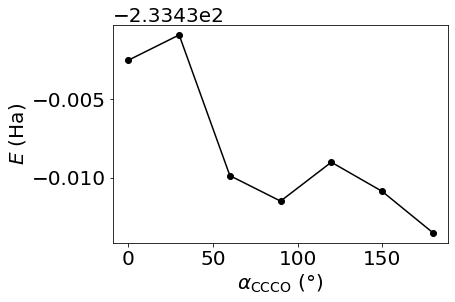

In [19]:
plt.rcParams['figure.figsize'] = [6,4]

plt.rcParams['font.size'] = 20
plt.plot(angle, e_npbc, '-o', color='black')
plt.xlabel(r'$\alpha_{\rm{CCCO}}$ (°)')
plt.ylabel(r'$E$ (Ha)')
plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/dihedral_total_energy_mol.svg', bbox_inches='tight')

#### Electronic energy molecule

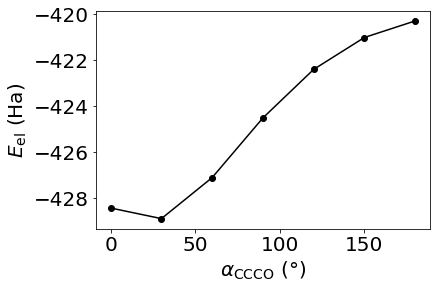

In [18]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['font.size'] = 20
plt.plot(angle, e_npbc-nuc_rep, '-o', color='black')
plt.xlabel(r'$\alpha_{\rm{CCCO}}$ (°)')
plt.ylabel(r'$E_{\rm{el}}$ (Ha)')
plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/dihedral_electronic_energy_mol.svg', bbox_inches='tight')

#### Alchemical Potentials

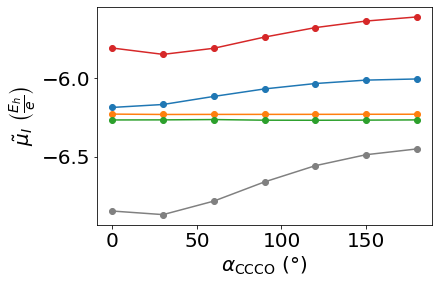

In [16]:
plt.rcParams['figure.figsize'] = [6,4]
fig, ax = plt.subplots(1,1)

#at = 'heavy'
at = 'heavy'

if at == 'heavy':
    ax.plot(angle, alchpots[:,0], '-o',label='C0')
    ax.plot(angle, alchpots[:,1], '-o',label='C1')
    ax.plot(angle, alchpots[:,2], '-o',label='C2')
    ax.plot(angle, alchpots[:,3], '-o',label='C3')
    ax.plot(angle, alchpots[:,4], '-o', label='O', color='grey')

    
# Hydrogens
if at == 'hydrogens':
    # C0
    ax.plot(angle, alchpots[:,5], '-o', color='tab:blue')
    ax.plot(angle, alchpots[:,6], '-o', color='tab:blue')
    # C1
    ax.plot(angle, alchpots[:,7], '-o', color='tab:orange')
    ax.plot(angle, alchpots[:,8], '-o', color='tab:orange')
    # C2
    ax.plot(angle, alchpots[:,9], '-o', color='tab:green')
    ax.plot(angle, alchpots[:,10], '-o', color='tab:green')
    # C3
    ax.plot(angle, alchpots[:,11], '-o', color='tab:red')
    ax.plot(angle, alchpots[:,12], '-o', color='tab:red')
    ax.plot(angle, alchpots[:,13], '-o', color='tab:red')
    # O
    ax.plot(angle, alchpots[:,14], '-o', color='tab:grey')

ax.set_xlabel(r'$\alpha_{\rm{CCCO}}$ (°)')
ax.set_ylabel(r'$\tilde{\mu}_I$ $\left(\frac{E_h}{e}\right)$')
#plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/dihedral_mu_hydrogens.svg', bbox_inches='tight')
plt.savefig('/home/misa/projects/atomic-energies/figures/butanol_geometry/dihedral_mu_heavy_atoms.svg', bbox_inches='tight')

In [ ]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_el[:,0], '-o',label='C0')
ax[0].plot(angle, e_el[:,1], '-o',label='C1')
ax[0].plot(angle, e_el[:,2], '-o',label='C2')
ax[0].plot(angle, e_el[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
#ax[0].legend()
ax[0].set_xlabel(r'$\alpha$ (°)')

ax[0].set_ylabel(r'$-Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|}$')


ax[1].plot(angle, e_el[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\alpha$ (°)')
#ax[1].set_ylabel(r'$Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|}$')
#ax[1].legend()

In [ ]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_tot[:,0], '-o',label='C0')
ax[0].plot(angle, e_tot[:,1], '-o',label='C1')
ax[0].plot(angle, e_tot[:,2], '-o',label='C2')
ax[0].plot(angle, e_tot[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].set_xlabel(r'$\alpha$ (°)')

ax[0].set_ylabel(r'$-Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|} + E_{\rm{NN}}$')


ax[1].plot(angle, e_tot[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\alpha$ (°)')
#ax[1].set_ylabel(r'$Z_I \int d\lambda \frac{\tilde{\rho}}{|\vec{r}-\vec{R}_I|} + E_{\rm{NN}}$')
#ax[1].legend()

In [ ]:
plt.rcParams['figure.figsize'] = [14,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(angle, e_scaled[:,0], '-o',label='C0')
ax[0].plot(angle, e_scaled[:,1], '-o',label='C1')
ax[0].plot(angle, e_scaled[:,2], '-o',label='C2')
ax[0].plot(angle, e_scaled[:,3], '-o',label='C3')
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].set_xlabel(r'$\alpha$ (°)')

ax[0].set_ylabel(r'$E_{\rm{scaled}}$')

ax[1].plot(angle, e_scaled[:,4], '-o', label='O', color='grey')
ax[1].set_xlabel(r'$\alpha$ (°)')
#ax[1].set_ylabel(r'$E_{\rm{scaled}}$')
#ax[1].legend()

In [ ]:
plt.rcParams['figure.figsize'] = [18,4]
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(1,3)

# Hydrogens
# C0
ax[0].plot(angle, e_scaled[:,5], '-o', color='tab:blue')
ax[0].plot(angle, e_scaled[:,6], '-o', color='tab:blue')
# C1
ax[0].plot(angle, e_scaled[:,7], '-o', color='tab:orange')
ax[0].plot(angle, e_scaled[:,8], '-o', color='tab:orange')
# C2
ax[0].plot(angle, e_scaled[:,9], '-o', color='tab:green')
ax[0].plot(angle, e_scaled[:,10], '-o', color='tab:green')
# C3
ax[0].plot(angle, e_scaled[:,11], '-o', color='tab:red')
ax[0].plot(angle, e_scaled[:,12], '-o', color='tab:red')
ax[0].plot(angle, e_scaled[:,13], '-o', color='tab:red')
# O
ax[0].plot(angle, e_scaled[:,14], '-o', color='tab:grey')

ax[0].set_xlabel(r'$\alpha$ (°)')
ax[0].set_ylabel(r'$E_{\rm{scaled}}$')

# Carbon
ax[1].plot(angle, e_scaled[:,0], '-o',label='C0')
ax[1].plot(angle, e_scaled[:,1], '-o',label='C1')
ax[1].plot(angle, e_scaled[:,2], '-o',label='C2')
ax[1].plot(angle, e_scaled[:,3], '-o',label='C3')
#ax[1].legend(bbox_to_anchor=(1.05,1))
ax[1].set_xlabel(r'$\alpha$ (°)')

# Oxygen
ax[2].plot(angle, e_scaled[:,4], '-o', label='O', color='grey')
ax[2].set_xlabel(r'$\alpha$ (°)')

fig.tight_layout()

### Angles - methane HCH

In [ ]:
paths_glob = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/methane_HCH/ang*/results2.dict')
angle = []
for p in paths_glob:
    angle.append(float(p.split('/')[-2].split('_')[-1]))
paths = []
for p,a in zip(paths_glob,angle):
    paths.append((a,p))
paths.sort()
angle.sort()
data = []
for p in paths:
    data.append(uqm.load_obj(p[1]))

e_npbc = []
for d in data:
    e_npbc.append(d['e_nbpc'])
    
e_scaled = []
for d in data:
    e_scaled.append(d['e_scaled'])
e_scaled = np.array(e_scaled)

In [ ]:
for d in data:
    Z = d['nuclei'][:,0]
    pos = d['nuclei'][:,1:]
    molecule = ase.Atoms(Z, pos)
    #print(molecule.get_angle(1,4,0))
    print(molecule.get_angle(1,4,2))
    #print(molecule.get_angle(1,4,3))

In [ ]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(4)
ax[0].plot(angle,e_npbc, '-o', label='npbc')
ax[0].set_ylabel('E (Ha)')

ax[1].plot(angle, e_scaled[:,0], '-o')
ax[1].plot(angle, e_scaled[:,1], '-o')
#ax[1].plot(angle, (e_scaled[:,0]+e_scaled[:,1])/2, '--o')

#ax[1].plot(angle, e_scaled[:,2], '-o')
#ax[1].plot(angle, e_scaled[:,3], '-o')
ax[1].set_ylabel('E_I scaled (Ha)')
angle2 = np.linspace(2,-2,5)
ax[2].plot(angle2, e_scaled[:,2], '-o')
ax[2].plot(angle2, e_scaled[:,3], '-o')
ax[2].plot(angle2, (e_scaled[:,2]+e_scaled[:,3])/2, '--o')

ax[3].plot(angle, e_scaled[:,4], '-o')
ax[3].set_ylabel('E_I scaled (Ha)')
ax[3].set_xlabel('dev eq (°)')


fig.tight_layout()

### Angles - ethene HCH

In [ ]:
paths_glob = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/ethene_HCH/ang*/results2.dict')
angle = []
for p in paths_glob:
    angle.append(float(p.split('/')[-2].split('_')[-1]))
paths = []
for p,a in zip(paths_glob,angle):
    paths.append((a,p))
paths.sort()
angle.sort()
data = []
for p in paths:
    data.append(uqm.load_obj(p[1]))

e_npbc = []
for d in data:
    e_npbc.append(d['e_nbpc'])
    
e_scaled = []
for d in data:
    e_scaled.append(d['e_scaled'])
e_scaled = np.array(e_scaled)

In [ ]:
for d in data:
    Z = d['nuclei'][:,0]
    pos = d['nuclei'][:,1:]
    molecule = ase.Atoms(Z, pos)
    print(molecule.get_angle(3,0,5))
    #print(molecule.get_angle(1,4,2))
    #print(molecule.get_angle(1,4,3))

In [ ]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(3)
ax[0].plot(angle,e_npbc, '-o', label='npbc')
ax[0].set_ylabel('E (Ha)')

ax[1].plot(angle, e_scaled[:,2], '-o', label='2')
ax[1].plot(angle, e_scaled[:,3], '-o', label='3')
ax[1].plot(angle, e_scaled[:,4], '-o', label='4')
ax[1].plot(angle, e_scaled[:,5], '-o', label='5')
ax[1].set_ylabel('E_I scaled (Ha)')
ax[1].legend()

ax[2].plot(angle, e_scaled[:,0], '-o')
ax[2].plot(angle, e_scaled[:,1], '-o')
ax[2].set_ylabel('E_I scaled (Ha)')
ax[2].set_xlabel('dev eq (°)')


fig.tight_layout()

### Angles - water

In [ ]:
paths_glob = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/water/ang*/results2.dict')
angle = []
for p in paths_glob:
    angle.append(float(p.split('/')[-2].split('_')[-1]))
paths = []
for p,a in zip(paths_glob,angle):
    paths.append((a,p))
paths.sort()
angle.sort()
data = []
for p in paths:
    data.append(uqm.load_obj(p[1]))

e_npbc = []
for d in data:
    e_npbc.append(d['e_nbpc'])
    
e_scaled = []
for d in data:
    e_scaled.append(d['e_scaled'])
e_scaled = np.array(e_scaled)

In [ ]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(3)
ax[0].plot(angle, e_npbc, '-o')
ax[0].set_ylabel('E (Ha)')
#plt.plot(angle,e_npbc, '-o', label='npbc')
ax[1].plot(angle, (e_scaled[:,0]+e_scaled[:,1])/2, '-o')
ax[1].set_ylabel('E_I scaled (Ha)')
ax[2].plot(angle, e_scaled[:,2], '-o')
ax[2].set_ylabel('E_I scaled (Ha)')
ax[2].set_xlabel('dev eq (°)')
fig.tight_layout()

### Dihedrals - ethane

In [ ]:
paths_glob = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/dihedrals/ethane/dihe*/results2.dict')
angle = []
for p in paths_glob:
    angle.append(float(p.split('/')[-2].split('_')[-1]))
paths = []
for p,a in zip(paths_glob,angle):
    paths.append((a,p))
paths.sort()
angle.sort()
data = []
for p in paths:
    data.append(uqm.load_obj(p[1]))

e_npbc = []
for d in data:
    e_npbc.append(d['e_nbpc'])
    
e_scaled = []
for d in data:
    e_scaled.append(d['e_scaled'])
e_scaled = np.array(e_scaled)

In [ ]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(4)
ax[0].plot(angle, e_npbc, '-o')
ax[0].set_ylabel('E (Ha)')

#plt.plot(angle,e_npbc, '-o', label='npbc')
ax[1].plot(angle, e_scaled[:,0], '-o')
ax[1].plot(angle, e_scaled[:,1], '-o')

ax[1].set_ylabel('E_I scaled (Ha)')

ax[2].plot(angle, e_scaled[:,2], '-o')
ax[2].plot(angle, e_scaled[:,7], '-o')
ax[2].set_ylabel('E_I scaled (Ha)')

ax[3].plot(angle, e_scaled[:,3], '-o')
ax[3].plot(angle, e_scaled[:,4], '-o')
ax[3].plot(angle, e_scaled[:,5], '-o')
ax[3].plot(angle, e_scaled[:,6], '-o')
ax[3].set_ylabel('E_I scaled (Ha)')
ax[3].set_xlabel('dev eq (°)')

fig.tight_layout()